# Random Forest
@Thiago Cunha Montenegro

First for our Random Sampling Model and Stratified Model our data pre process consist:
1. Drop the following columns:
  * SID, NAME, YEAR, COORDS, COORDS_MAX_WINDS	COORDS_MIN_DIST2LAND, BASIN (Redudant Information), DATE_START	DATE_END	DATE_LAND_START	DATE_LAND_END
2. Handle Missing Values using Imputer:
  * For numerical columns fill with Mean or Median: I choose mean.
  * For Categorical columns use KNN: As we don't have any missing values i didnt use KNN imputer


# Results
I run three Random Forest Models,
Our first model generated using simple random, had satisfactory results, which was expected due to our very limited data set.
However, when generating our model, using stratification, we have a huge difference, which is extremely positive, for this second model, we had an accuracy improvement of 37%.
This demonstrates that stratification has generated better results and reduces our bias in our model

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error,mean_squared_log_error,median_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv('/content/OUTPUT_WBI_exposer_cyclones_v14.csv', sep = ';')

# Random Forest Regressor With Recommended Feature Selection

In [3]:
df.head()

,SID,NAME,ISO,YEAR,COORDS,COORDS_MAX_WINDS,COORDS_MIN_DIST2LAND,BASIN,SUB BASIN,MONTH_START,MONTH_END,DATE_START,DATE_END,DATE_LAND_START,DATE_LAND_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,34KN_POP,64KN_POP,96KN_POP,64KN_ASSETS,34KN_ASSETS,96KN_ASSETS,TOTAL_DAMAGE_(000$),TOTAL_DEATHS,POP_DEN_SQ_KM,RURAL_POP(%),HDI,Arable land (hectares per person),Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED
0,1949163N07145,DELLA,JPN,1949,"[(21.5, 125.424), (22.2, 125.8), (22.9089, 126...","[(27.6584, 128.82), (28.9141, 129.572999999999...","[(31.9866, 130.683), (33.5183, 130.97299999999...",WP,WP,6,6,19/06/1949 9:00,24/06/1949 6:00,20/06/1949 15:00,23/06/1949 3:00,117.0,60.0,TS,Cat 4,116.0,952,0,33.0,3,0,99.82,3889.480640,3632.626180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,419.0,195.0,77.20,0.816,0.059615,4173.5,67.79,8607.657082,0.0,67.666098,2.867878,Low,1.198300e+07,5.803981e+06,3.320907e+06,194046
1,1950241N23140,JANE,JPN,1950,"[(23.8845, 139.74), (23.9335, 139.639), (23.98...","[(28.7509, 133.748), (29.1201, 133.762), (29.6...","[(34.9374, 135.476), (36.1016, 136.095), (37.2...",WP,WP,8,9,30/08/1950 3:00,05/09/1950 0:00,03/09/1950 3:00,04/09/1950 0:00,141.0,21.0,ET,Cat 4,116.0,940,0,31.0,3,1,99.82,3596.090691,2787.480021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,509.0,227.0,47.00,0.816,0.059615,4173.5,67.79,8607.657082,0.0,67.666098,2.867878,Low,3.160822e+07,1.559196e+07,1.018936e+07,642117
2,1951224N12316,CHARLIE,JAM,1951,"[(17.3398, -75.4138), (17.6, -76.2), (17.9, -7...","[(17.6, -76.2), (17.9, -76.9)]","[(17.9, -76.9), (18.1, -77.8)]",NAm,CS,8,8,17/08/1951 21:00,18/08/1951 12:00,18/08/1951 3:00,18/08/1951 6:00,15.0,3.0,TS,Cat 3,110.0,0,0,17.0,3,3,132.40,438.214691,435.729082,2788659.0,2788659.0,2552903.0,2.148198e+10,2.148198e+10,1.948346e+10,56000.0,154.0,133.0,66.23,0.668,0.100541,868.3,69.93,3796.219401,0.0,64.770000,2.578304,Low,1.689243e+06,1.687083e+06,1.195052e+06,20200
3,1951337N09150,AMY,PHL,1951,"[(12.0725, 130.967), (12.1333, 130.517), (12.1...","[(11.7833, 127.9)]","[(10.7333, 124.8), (10.534, 123.174), (10.6833...",WP,WP,12,12,07/12/1951 9:00,17/12/1951 0:00,09/12/1951 12:00,11/12/1951 0:00,231.0,36.0,TS,Cat 4,120.0,924,0,11.0,4,2,119.20,2238.058669,1905.587795,20464826.0,12675908.0,5618193.0,1.131050e+11,1.880280e+11,4.897333e+10,NaN,569.0,64.5,75.35,0.590,0.180442,996.3,25.68,1059.467412,0.0,61.105000,2.757732,Low_Middle,4.760039e+06,3.006670e+06,1.114774e+06,60000
4,1952180N05144,EMMA,PHL,1952,"[(9.33776, 130.185), (9.38633, 129.61), (9.45,...","[(9.45, 129.017), (9.50407, 128.407), (9.56613...","[(10.4667, 123.867), (10.6492, 123.239), (10.8...",WP,WP,7,7,01/07/1952 6:00,04/07/1952 18:00,02/07/1952 12:00,02/07/1952 21:00,84.0,9.0,TS,Cat 3,110.0,968,0,15.0,3,1,110691.00,1876.186790,1797.712213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,66.9,72.41,0.590,0.180442,996.3,25.68,1059.467412,0.0,61.105000,2.757732,Low_Middle,5.130796e+06,2.789486e+06,1.988524e+06,103


In [4]:
df.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'COORDS_MAX_WINDS',
       'COORDS_MIN_DIST2LAND', 'BASIN', 'SUB BASIN', 'MONTH_START',
       'MONTH_END', 'DATE_START', 'DATE_END', 'DATE_LAND_START',
       'DATE_LAND_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN',
       'DISTANCE_TRACK', 'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP',
       '96KN_POP', '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'HDI', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final'

In [5]:
df.dtypes

SID                                                    object
NAME                                                   object
ISO                                                    object
YEAR                                                    int64
COORDS                                                 object
COORDS_MAX_WINDS                                       object
COORDS_MIN_DIST2LAND                                   object
BASIN                                                  object
SUB BASIN                                              object
MONTH_START                                             int64
MONTH_END                                               int64
DATE_START                                             object
DATE_END                                               object
DATE_LAND_START                                        object
DATE_LAND_END                                          object
TOTAL_HOURS_EVENT                                     float64
TOTAL_HO

In [6]:
df.corr(method="spearman")['TOTAL_AFFECTED'].sort_values(ascending = False)

TOTAL_AFFECTED                                        1.000000
TOTAL_DEATHS                                          0.521623
34KN_POP                                              0.313103
Net flows from UN agencies US$                        0.295261
TOTAL_DAMAGE_(000$)                                   0.287962
64KN_POP                                              0.260846
RURAL_POP(%)                                          0.249751
POP_MAX_64_ADJ                                        0.212022
TOTAL_HOURS_IN_LAND                                   0.209744
POP_MAX_50_ADJ                                        0.201107
POP_MAX_34_ADJ                                        0.188636
96KN_POP                                              0.184835
V_LAND_KN                                             0.143085
64KN_ASSETS                                           0.137412
96KN_ASSETS                                           0.136412
MAX_WIND                                              0

In [0]:
def null_cols(data):

    """
    This function takes a dataframe df and shows the columns of df that have NaN values
    and the number of them

    """
    nulls = data.isna().sum()
    nulls = nulls[nulls > 0] / len(data) * 100
    nulls = pd.DataFrame(nulls.sort_values(ascending = False))
    nulls = nulls.reset_index().rename(columns = {"index": "Feature", 0: "% Null rows"})
    return nulls


In [8]:
null_cols(df)

,Feature,% Null rows
0,TOTAL_DAMAGE_(000$),31.584258
1,64KN_ASSETS,23.309788
2,34KN_ASSETS,23.309788
3,96KN_ASSETS,23.309788
4,34KN_POP,23.208880
5,64KN_POP,23.208880
6,96KN_POP,23.208880
7,TOTAL_DEATHS,13.118063
8,POP_MAX_50_ADJ,8.072654
9,POP_MAX_64_ADJ,8.072654


In [9]:
df.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'COORDS_MAX_WINDS',
       'COORDS_MIN_DIST2LAND', 'BASIN', 'SUB BASIN', 'MONTH_START',
       'MONTH_END', 'DATE_START', 'DATE_END', 'DATE_LAND_START',
       'DATE_LAND_END', 'TOTAL_HOURS_EVENT', 'TOTAL_HOURS_IN_LAND', 'NATURE',
       'GENERAL_CATEGORY', 'MAX_WIND', 'MIN_PRES', 'MIN_DIST2LAND',
       'MAX_STORMSPEED', 'MAX_USA_SSHS', 'MAX_USA_SSHS_INLAND', 'V_LAND_KN',
       'DISTANCE_TRACK', 'DISTANCE_TRACK_VINCENTY', '34KN_POP', '64KN_POP',
       '96KN_POP', '64KN_ASSETS', '34KN_ASSETS', '96KN_ASSETS',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS', 'POP_DEN_SQ_KM', 'RURAL_POP(%)',
       'HDI', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final'

In [10]:
df['MAX_USA_SSHS_INLAND'].value_counts()

0             272
No landing    218
1             161
-1             97
2              91
3              80
4              43
5               9
-4              8
-3              7
-2              2
-5              2
-6              1
Name: MAX_USA_SSHS_INLAND, dtype: int64

In [11]:
df[df['MAX_USA_SSHS_INLAND'] == 'No landing']

,SID,NAME,ISO,YEAR,COORDS,COORDS_MAX_WINDS,COORDS_MIN_DIST2LAND,BASIN,SUB BASIN,MONTH_START,MONTH_END,DATE_START,DATE_END,DATE_LAND_START,DATE_LAND_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,34KN_POP,64KN_POP,96KN_POP,64KN_ASSETS,34KN_ASSETS,96KN_ASSETS,TOTAL_DAMAGE_(000$),TOTAL_DEATHS,POP_DEN_SQ_KM,RURAL_POP(%),HDI,Arable land (hectares per person),Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED
24,1965239N11310,BETSY,BHS,1965,"[(24.1, -71.3), (24.4076, -71.67), (24.7, -72....","[(26.9, -74.3), (27.0848, -74.5006), (27.3, -7...","[(25.3, -77.9), (25.2572, -78.1775)]",NAm,NAm,9,9,03/09/1965 0:00,08/09/1965 6:00,No landing,No landing,126.0,0.0,TS,Cat 4,120.0,943,24,12.0,4,No landing,113.8,1431.679414,837.666210,351933.0,278609.0,259136.0,7.957300e+09,1.152358e+10,6.561886e+09,700.0,NaN,14.0,36.70,0.639,0.049979,909.100000,42.600000,22863.647690,0.000000e+00,65.310000,3.300000,High,1.098296e+04,8.034054e+02,192.313888,1200
27,1966171N09151,KIT,JPN,1966,"[(19.2429, 130.743), (19.9252, 130.783), (20.6...","[(20.6121, 130.878), (21.335, 131.037999999999...","[(45.7876, 150.71200000000005)]",WP,WP,6,7,26/06/1966 0:00,01/07/1966 0:00,No landing,No landing,120.0,0.0,ET,Cat 5,174.0,880,38,34.0,5,No landing,104.5,3849.412605,3587.375091,1264381.0,8194.0,7256.0,1.220941e+09,2.282110e+11,1.112412e+09,NaN,44.0,273.0,31.30,0.816,0.054645,4509.300000,80.420000,13808.697940,0.000000e+00,70.986585,2.867878,Low,2.341732e+06,0.000000e+00,0.000000,80
29,1966265N10325,INEZ,BHS,1966,"[(24.6, -79.1), (24.7725, -78.9423), (24.9, -7...","[(25.6, -78.4), (25.58, -78.655), (25.5, -79.0...","[(25.3075, -78.37)]",NAm,NAm,10,10,03/10/1966 0:00,04/10/1966 12:00,No landing,No landing,36.0,0.0,TS,Cat 1,75.0,985,37,7.0,1,No landing,85.6,283.123462,98.408066,340996.0,3187.0,0.0,3.617559e+08,1.090226e+10,0.000000e+00,15500.0,5.0,14.6,36.00,0.639,0.047820,914.900000,46.170000,23860.627290,0.000000e+00,65.402000,3.300000,High,3.160626e+04,4.157686e+02,10.624000,3
31,1966265N10325,INEZ,HTI,1966,"[(18.1, -72.3), (18.4575, -72.9874), (18.8, -7...","[(18.1, -72.3)]","[(18.1, -72.3), (18.4575, -72.9874)]",NAm,CS,9,9,29/09/1966 18:00,30/09/1966 6:00,No landing,No landing,12.0,0.0,TS,Cat 3,100.0,987,11,15.0,3,No landing,131.2,267.414765,267.373766,10501742.0,6950819.0,4097835.0,1.444215e+10,2.226862e+10,7.533611e+09,20000.0,480.0,158.0,82.00,0.433,0.207310,1075.800000,71.740000,907.884216,0.000000e+00,44.267000,1.284442,Low_Middle,4.523588e+06,2.366243e+06,606221.263500,67881
35,1967186N15220,BEULAH,USA,1967,"[(14.8, -140.0), (14.9851, -140.347), (15.2, -...","[(14.8, -140.0), (14.9851, -140.347), (15.2, -...","[(17.9492, -155.75)]",EP,CP,7,7,05/07/1967 6:00,08/07/1967 0:00,No landing,No landing,66.0,0.0,NR,TD,25.0,0,111,27.0,-1,No landing,135.7,2400.316282,2375.011958,3156586.0,1643385.0,641522.0,3.100980e+11,6.541250e+11,1.012560e+11,200000.0,15.0,22.3,27.40,0.862,0.878090,3161.200000,53.680000,22220.198950,0.000000e+00,70.560976,7.454724,High,1.943252e+06,1.053652e+06,412445.799500,30000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,2018197N19128,SON-TINH,PHL,2018,"[(18.9, 128.4), (19.0125, 127.681), (19.2, 126...","[(19.4, 118.325)]","[(18.75, 122.45)]",WP,WP,7,7,15/07/2018 12:00,17/07/2018 0:00,No landing,No landing,36.0,0.0,NR,TS,40.0,995,49,25.0,0,No landing,45.9,1078.100133,1061.155266,NaN,NaN,NaN,NaN,NaN,NaN,25944.0,NaN,357.0,53.10,0.712,0.054574,3574.661515,115.645889,3021.986863,2.025966e+07,7

In [0]:

def handle_landing(df):
  df['Landing'] = [0 if x == 'No landing' else 1 for x in df['MAX_USA_SSHS_INLAND']]
  df['MAX_USA_SSHS_INLAND'] = df['MAX_USA_SSHS_INLAND'].replace('No landing', '-7') #New categorie for No landing variable
  return df

def handle_usa_sshs(df):
  df["MAX_USA_SSHS"]= df["MAX_USA_SSHS"].replace(-6, np.nan) 
  df["MAX_USA_SSHS_INLAND"]= df["MAX_USA_SSHS_INLAND"].replace('-6', np.nan)
  df['MAX_USA_SSHS_INLAND'] = df['MAX_USA_SSHS_INLAND'].astype(float)
  return df

def calculate_assets(df):
  df['CALC_assets_emdat'] = df['34KN_ASSETS'] + df['64KN_ASSETS'] + df['96KN_ASSETS']
  return df

def process_income_final(df):
  """
    Process the Income Final Level column into numerical

    Usage
    ------

    df = process_total_damaged(df)
  """
  #Arnab code
  unique_list = df['Income_level_Final'].unique()
  incomelevel_to_int = dict(zip(unique_list, [1,2,4,3])) # so we assign['Low' =1, 'Low_Middle' =2, 'High'=4, 'High_Middle'=3]
  df['Income_level_Final'] = df['Income_level_Final'].apply(lambda inc_level: incomelevel_to_int[inc_level])
  return df


def drop_columns(df):
  columns_to_drop = ['SID','NAME','YEAR','BASIN','COORDS','COORDS_MAX_WINDS', 'COORDS_MIN_DIST2LAND','DATE_START','DATE_LAND_END','DATE_LAND_START','DATE_END','34KN_ASSETS','64KN_ASSETS','96KN_ASSETS','34KN_POP','64KN_POP','96KN_POP', 'TOTAL_DAMAGE_(000$)','TOTAL_DEATHS']
  df = df.drop(columns_to_drop, axis = 1)
  return df

def create_dummies(df, column_name):
   """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    df = create_dummies(train, categorical_column)
    """
   dummies = pd.get_dummies(df[column_name], prefix=column_name)
   df = pd.concat([df,dummies],axis=1)
   return df

from sklearn.model_selection import GridSearchCV

def select_model(df,features):
    
    all_X = df.drop('TOTAL_AFFECTED', axis = 1)
    all_y = df["TOTAL_AFFECTED"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        
        {
            "name": "RandomForestRegressor",
            "estimator": RandomForestRegressor(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [100, 300,500, 700, 1000],
                    "criterion": ["mse"],
                    "max_depth": [2, 5, 10, 12],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10, n_jobs = -1)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

def get_results(predictions, y_test, score):
 
  mse = mean_squared_error(y_test, predictions)
  print(f'Mean Squared Error: {mse:.2f}')
  rmse = np.sqrt(mse)
  print(f'Root Mean Squared Error: {rmse:.2f}')
  mae = mean_absolute_error(y_test, predictions)
  print(f'Mean Absolute Error: {mae:.2f}')
  #Variance score: 1 is perfect prediction score
  explained_variance = explained_variance_score(y_test, predictions)
  print(f'Explained Variance Score: {explained_variance:.3f}')
  msle = mean_squared_log_error(y_test, predictions)
  print(f'Mean Squared Log Error: {msle:.2f}')
  median_ae = median_absolute_error(y_test, predictions)
  print(f'Median Absolute Error: {median_ae:.2f}')
  print(f'R^2 Prediction Score: {score:.4f}')

def get_dummies(df, columns):
  pass
def data_preprocessing(df):
  df = handle_landing(df)
  df = handle_usa_sshs(df)
  df = process_income_final(df)
  df = drop_columns(df)
  return df



In [0]:

df = data_preprocessing(df)


In [14]:
df.isnull().sum()

ISO                                                    0
SUB BASIN                                              0
MONTH_START                                            0
MONTH_END                                              0
TOTAL_HOURS_EVENT                                      0
TOTAL_HOURS_IN_LAND                                    0
NATURE                                                 0
GENERAL_CATEGORY                                       0
MAX_WIND                                               0
MIN_PRES                                               0
MIN_DIST2LAND                                          0
MAX_STORMSPEED                                         2
MAX_USA_SSHS                                           1
MAX_USA_SSHS_INLAND                                    1
V_LAND_KN                                              0
DISTANCE_TRACK                                         0
DISTANCE_TRACK_VINCENTY                                0
POP_DEN_SQ_KM                  

In [15]:
null_df = null_cols(df)
null_columns = null_df['Feature']
null_columns

0                                        POP_MAX_64_ADJ
1                                        POP_MAX_50_ADJ
2                                        POP_MAX_34_ADJ
3     Adjusted savings: education expenditure (% of ...
4                         Cereal yield (kg per hectare)
5                    GDP per capita (constant 2010 US$)
6               Life expectancy at birth, total (years)
7               Food production index (2004-2006 = 100)
8                                        MAX_STORMSPEED
9                     Arable land (hectares per person)
10                                  MAX_USA_SSHS_INLAND
11                                         MAX_USA_SSHS
Name: Feature, dtype: object

In [0]:
imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
for cols in null_columns:
    df[cols] = imputer.fit_transform(df[[cols]])

In [17]:
cat_columns = df.dtypes[df.dtypes == 'object'].index
print(cat_columns)
for categorical in cat_columns:
  df = create_dummies(df,categorical)
  df = df.drop(categorical, axis = 1)

Index(['ISO', 'SUB BASIN', 'NATURE', 'GENERAL_CATEGORY'], dtype='object')


In [18]:
df

,MONTH_START,MONTH_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,POP_DEN_SQ_KM,RURAL_POP(%),HDI,Arable land (hectares per person),Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED,Landing,ISO_AUS,ISO_BGD,ISO_BHS,ISO_BLZ,ISO_CAN,ISO_CHN,ISO_COL,ISO_COM,ISO_CRI,ISO_CUB,ISO_CYM,...,ISO_SWZ,ISO_TCA,ISO_THA,ISO_TON,ISO_TTO,ISO_TWN,ISO_USA,ISO_VEN,ISO_VIR,ISO_VNM,ISO_VUT,ISO_WSM,ISO_YEM,ISO_ZAF,ISO_ZWE,SUB BASIN_AS,SUB BASIN_BB,SUB BASIN_CP,SUB BASIN_CS,SUB BASIN_EA,SUB BASIN_EP,SUB BASIN_GM,SUB BASIN_NAm,SUB BASIN_SI,SUB BASIN_SP,SUB BASIN_WA,SUB BASIN_WP,NATURE_DS,NATURE_ET,NATURE_MX,NATURE_NR,NATURE_SS,NATURE_TS,GENERAL_CATEGORY_Cat 1,GENERAL_CATEGORY_Cat 2,GENERAL_CATEGORY_Cat 3,GENERAL_CATEGORY_Cat 4,GENERAL_CATEGORY_Cat 5,GENERAL_CATEGORY_TD,GENERAL_CATEGORY_TS
0,6,6,117.0,60.0,116.0,952,0,33.0,3.0,0.0,99.82,3889.480640,3632.626180,195.0,77.20,0.816,0.059615,4173.500000,67.790000,8607.657082,0.0,67.666098,2.867878,1,1.198300e+07,5.803981e+06,3.320907e+06,194046,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
1,8,9,141.0,21.0,116.0,940,0,31.0,3.0,1.0,99.82,3596.090691,2787.480021,227.0,47.00,0.816,0.059615,4173.500000,67.790000,8607.657082,0.0,67.666098,2.867878,1,3.160822e+07,1.559196e+07,1.018936e+07,642117,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
2,8,8,15.0,3.0,110.0,0,0,17.0,3.0,3.0,132.40,438.214691,435.729082,133.0,66.23,0.668,0.100541,868.300000,69.930000,3796.219401,0.0,64.770000,2.578304,1,1.689243e+06,1.687083e+06,1.195052e+06,20200,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,12,12,231.0,36.0,120.0,924,0,11.0,4.0,2.0,119.20,2238.058669,1905.587795,64.5,75.35,0.590,0.180442,996.300000,25.680000,1059.467412,0.0,61.105000,2.757732,2,4.760039e+06,3.006670e+06,1.114774e+06,60000,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
4,7,7,84.0,9.0,110.0,968,0,15.0,3.0,1.0,110691.00,1876.186790,1797.712213,66.9,72.41,0.590,0.180442,996.300000,25.680000,1059.467412,0.0,61.105000,2.757732,2,5.130796e+06,2.789486e+06,1.988524e+06,103,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,3,3,126.0,0.0,105.0,944,70,12.0,3.0,-7.0,151.20,957.628405,522.204526,39.9,64.10,0.217,0.204973,831.865274,147.309625,585.650609,0.0,58.508514,5.380000,1,2.396895e+06,0.000000e+00,0.000000e+00,1501500,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
987,3,3,63.0,0.0,105.0,956,77,7.0,3.0,-7.0,151.20,404.150545,211.930107,46.4,62.10,0.404,0.141861,3825.634771,121.054617,478.761938,0.0,66.012095,2.080000,1,2.341183e+05,0.000000e+00,0.000000e+00,1100,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
988,4,4,27.0,0.0,124.0,937,138,13.0,4.0,-7.0,118.80,486.400190,484.370217,457.0,71.04,0.402,0.082332,1354.663449,108.375163,1375.714129,0.0,63.742834,4.326607,2,2.770093e+07,1.504009e+07,5.948569e+06,345311,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
989,4,4,27.0,21.0,121.0,939,0,

## Model

In [0]:
X = df.drop('TOTAL_AFFECTED', axis = 1)
y = df['TOTAL_AFFECTED']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 101)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((693, 115), (298, 115), (693,), (298,))

In [22]:
rfr = RandomForestRegressor(criterion = 'mse', max_depth = 10, max_features = 'log2', min_samples_leaf = 8, min_samples_split =  2, n_estimators = 300)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
predictions = rfr.predict(X_test)

In [24]:
score = rfr.score(X_train,y_train)

get_results(predictions, y_test, score)

Mean Squared Error: 3505244312814.24
Root Mean Squared Error: 1872229.77
Mean Absolute Error: 719143.19
Explained Variance Score: 0.136
Mean Squared Log Error: 15.70
Median Absolute Error: 318549.97
R^2 Prediction Score: 0.2946


# Random Forest With Stratified Sampling



In [0]:
df1 = pd.read_csv('/content/OUTPUT_WBI_exposer_cyclones_v14.csv', sep = ';')

In [26]:
corr = df1.corr()
corr['TOTAL_AFFECTED'].sort_values(ascending=False)

TOTAL_AFFECTED                                        1.000000
POP_MAX_50_ADJ                                        0.386008
POP_MAX_34_ADJ                                        0.310021
POP_MAX_64_ADJ                                        0.209224
Net flows from UN agencies US$                        0.209217
34KN_POP                                              0.203314
96KN_POP                                              0.177712
64KN_POP                                              0.159537
RURAL_POP(%)                                          0.119284
TOTAL_HOURS_IN_LAND                                   0.103834
MAX_WIND                                              0.101703
MAX_USA_SSHS                                          0.081092
Cereal yield (kg per hectare)                         0.077063
YEAR                                                  0.071657
POP_DEN_SQ_KM                                         0.067337
TOTAL_DEATHS                                          0

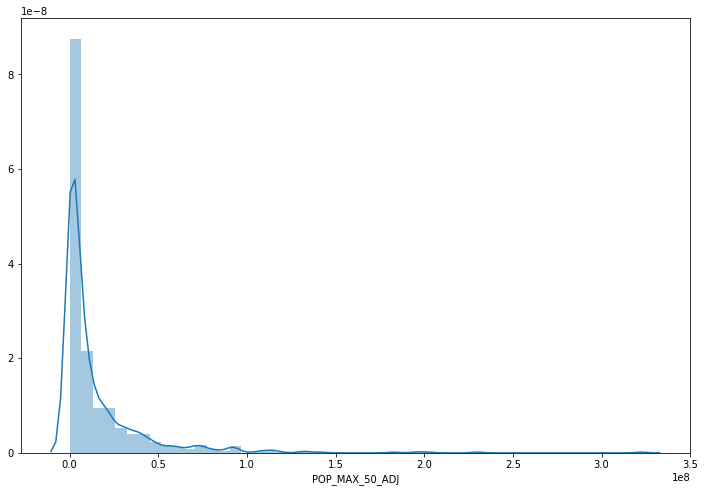

In [53]:
plt.figure(figsize = (12,8))
sns.distplot(df1['POP_MAX_50_ADJ']) # showing the distribution of thePOP_MAX_50_ADJ variable in the dataset
plt.show()                              

In [28]:

# Divide by 1.5 to limit the number of income categories
df1['POP_MAX_50_ADJ_CATEGORIES'] = np.ceil(df1["POP_MAX_50_ADJ"] / 1.5)

# showing the frequency of each category
df1['POP_MAX_50_ADJ_CATEGORIES']

0       3869321.0
1      10394642.0
2       1124723.0
3       2004447.0
4       1859658.0
          ...    
986           0.0
987           0.0
988           NaN
989      481334.0
990     1448963.0
Name: POP_MAX_50_ADJ_CATEGORIES, Length: 991, dtype: float64

In [0]:

df1["POP_MAX_50_ADJ_CATEGORIES"].where(df1["POP_MAX_50_ADJ_CATEGORIES"] < 5, 5.0, inplace = True)

In [30]:
df1['POP_MAX_50_ADJ_CATEGORIES']

0      5.0
1      5.0
2      5.0
3      5.0
4      5.0
      ... 
986    0.0
987    0.0
988    5.0
989    5.0
990    5.0
Name: POP_MAX_50_ADJ_CATEGORIES, Length: 991, dtype: float64

In [31]:
# importing the split class
from sklearn.model_selection import StratifiedShuffleSplit

# instantiating the class and aplitting 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# smiple loop to stratify by category and store the values in strat_train and test sets
for train_index, test_index in split.split(df1, df1["POP_MAX_50_ADJ_CATEGORIES"]):
    strat_train_set = df1.loc[train_index]
    strat_test_set = df1.loc[test_index]
    
# view the first five rows of the dataframe
strat_test_set.head()

,SID,NAME,ISO,YEAR,COORDS,COORDS_MAX_WINDS,COORDS_MIN_DIST2LAND,BASIN,SUB BASIN,MONTH_START,MONTH_END,DATE_START,DATE_END,DATE_LAND_START,DATE_LAND_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,34KN_POP,64KN_POP,96KN_POP,64KN_ASSETS,34KN_ASSETS,96KN_ASSETS,TOTAL_DAMAGE_(000$),TOTAL_DEATHS,POP_DEN_SQ_KM,RURAL_POP(%),HDI,Arable land (hectares per person),Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED,POP_MAX_50_ADJ_CATEGORIES
346,1997152N10265,ANDRES,SLV,1997,"[(12.4, -90.3), (12.1624, -89.92), (12.0, -89....","[(12.4, -90.3)]","[(13.1541, -88.7972), (13.36, -88.7676), (13.7...",EP,EP,6,6,06/06/1997 0:00,07/06/1997 6:00,07/06/1997 1:00,07/06/1997 6:00,30.0,5.0,TS,TS,35.0,1001,0,9.0,0,-1,38.2,348.407740,225.386505,472020.0,0.0,0.0,0.000000e+00,5.851525e+09,0.000000e+00,NaN,4.0,276.0,43.5,0.590,0.098324,1736.3,92.18,2575.532682,9.150000e+06,67.978,2.282577,Low_Middle,5.935324e+06,4.217566e+06,2.939487e+05,2000,5.0
410,2000273N16277,KEITH,BLZ,2000,"[(17.9, -86.565), (17.9, -86.7), (17.9, -86.8)...","[(17.9, -87.2), (17.9, -87.3)]","[(17.9, -88.2), (18.0, -88.4), (18.1397, -88.5...",NAm,CS,9,10,30/09/2000 15:00,03/10/2000 9:00,03/10/2000 3:00,03/10/2000 9:00,66.0,6.0,TS,Cat 4,120.0,939,0,5.0,4,0,103.2,286.563229,214.974371,318242.0,185934.0,14.0,1.414290e+09,2.878352e+09,7.958170e+05,277460.0,14.0,10.8,54.6,0.643,0.258779,2418.3,90.74,3783.540517,1.310000e+06,68.847,5.120000,High_Middle,3.498301e+05,1.686292e+05,6.340471e+04,62570,5.0
244,1991220N10133,FRED,CHN,1991,"[(19.7023, 116.869), (19.875, 116.475), (19.93...","[(20.3, 110.425), (20.1375, 109.895), (19.9, 1...","[(19.6036, 109.053), (19.3, 108.725)]",WP,WP,8,8,14/08/1991 9:00,17/08/1991 0:00,16/08/1991 9:00,16/08/1991 12:00,63.0,3.0,TS,Cat 2,95.0,955,0,12.0,2,2,114.4,1058.878992,995.584701,21196546.0,6647775.0,1385685.0,1.519590e+11,4.963970e+11,2.960650e+10,110000.0,14.0,127.0,72.7,0.509,0.108513,4231.4,49.62,786.129659,1.130300e+08,69.242,1.786179,Low_Middle,1.546029e+07,1.689557e+07,1.949974e+06,33424,5.0
897,2016253N13144,MERANTI,CHN,2016,"[(24.7801, 117.981), (25.225, 117.575), (25.70...","[(24.7801, 117.981)]","[(24.7801, 117.981), (25.225, 117.575), (25.70...",WP,WP,9,9,14/09/2016 21:00,16/09/2016 21:00,14/09/2016 21:00,16/09/2016 9:00,48.0,36.0,TS,Cat 1,80.0,955,0,20.0,1,1,170.1,1296.649929,1127.382900,NaN,NaN,NaN,NaN,NaN,NaN,2300000.0,NaN,149.0,43.3,0.749,0.086243,5980.9,139.03,6883.895425,4.023751e+07,76.210,1.790000,High_Middle,2.497988e+08,1.282613e+08,6.240051e+07,205500,5.0
663,2008252N16128,SINLAKU,TWN,2008,"[(24.6184, 122.135), (24.7, 121.85), (24.574, ...","[(24.6184, 122.135)]","[(24.574, 121.754), (24.5218, 121.762), (24.51...",WP,WP,9,9,13/09/2008 15:00,14/09/2008 18:00,13/09/2008 20:00,14/09/2008 3:00,27.0,7.0,TS,Cat 2,95.0,947,0,7.0,2,2,98.8,237.775383,182.965754,16854943.0,10256988.0,173.0,2.045850e+12,3.524890e+12,3.135230e+08,26400.0,22.0,648.0,26.3,0.790,0.081618,5548.4,113.95,3796.633363,4.493000e+07,73.835,1.790000,High_Middle,1.985282e+07,1.601066e+07,9.475261e+06,20,5.0


In [0]:
for set_ in (strat_train_set, strat_test_set):    # dropping the unwanted POP_MAX_50_ADJ_CATEGORIES for bith strat train and test sets
    set_.drop("POP_MAX_50_ADJ_CATEGORIES", axis=1, inplace=True)

In [33]:

df1 = strat_train_set.drop('TOTAL_AFFECTED', axis=1)    # creating the train set
df1_labels = strat_train_set['TOTAL_AFFECTED'].copy()  # creating the test set
df1_labels.head()       

178      6696
684    248058
467    162086
601     33188
949    160077
Name: TOTAL_AFFECTED, dtype: int64

In [0]:
aux_df1 = pd.DataFrame()

aux_df1 = data_preprocessing(df1)

In [35]:
aux_df1.isnull().sum()

ISO                                                    0
SUB BASIN                                              0
MONTH_START                                            0
MONTH_END                                              0
TOTAL_HOURS_EVENT                                      0
TOTAL_HOURS_IN_LAND                                    0
NATURE                                                 0
GENERAL_CATEGORY                                       0
MAX_WIND                                               0
MIN_PRES                                               0
MIN_DIST2LAND                                          0
MAX_STORMSPEED                                         2
MAX_USA_SSHS                                           1
MAX_USA_SSHS_INLAND                                    1
V_LAND_KN                                              0
DISTANCE_TRACK                                         0
DISTANCE_TRACK_VINCENTY                                0
POP_DEN_SQ_KM                  

In [36]:
# Checking Columns with null values to fill them using Imputer
null_df = null_cols(aux_df1)
null_columns = null_df['Feature']
null_columns




0                                        POP_MAX_64_ADJ
1                                        POP_MAX_50_ADJ
2                                        POP_MAX_34_ADJ
3                         Cereal yield (kg per hectare)
4     Adjusted savings: education expenditure (% of ...
5                    GDP per capita (constant 2010 US$)
6               Life expectancy at birth, total (years)
7               Food production index (2004-2006 = 100)
8                                        MAX_STORMSPEED
9                     Arable land (hectares per person)
10                                  MAX_USA_SSHS_INLAND
11                                         MAX_USA_SSHS
Name: Feature, dtype: object

In [0]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

for cols in null_columns:
    aux_df1[cols] = imputer.fit_transform(aux_df1[[cols]])

In [38]:
aux_df1.isnull().sum()

ISO                                                   0
SUB BASIN                                             0
MONTH_START                                           0
MONTH_END                                             0
TOTAL_HOURS_EVENT                                     0
TOTAL_HOURS_IN_LAND                                   0
NATURE                                                0
GENERAL_CATEGORY                                      0
MAX_WIND                                              0
MIN_PRES                                              0
MIN_DIST2LAND                                         0
MAX_STORMSPEED                                        0
MAX_USA_SSHS                                          0
MAX_USA_SSHS_INLAND                                   0
V_LAND_KN                                             0
DISTANCE_TRACK                                        0
DISTANCE_TRACK_VINCENTY                               0
POP_DEN_SQ_KM                                   

In [39]:
# We had some categorical columns we need to use OneHotEncoding
aux_df1.dtypes[df1.dtypes == 'object'].index

Index(['ISO', 'SUB BASIN', 'NATURE', 'GENERAL_CATEGORY'], dtype='object')

In [0]:
cat_columns = aux_df1.dtypes[aux_df1.dtypes == 'object'].index
for categorical in cat_columns:
  aux_df1 = create_dummies(aux_df1,categorical)
  aux_df1 = aux_df1.drop(categorical, axis = 1)

In [41]:
aux_df1

,MONTH_START,MONTH_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,POP_DEN_SQ_KM,RURAL_POP(%),HDI,Arable land (hectares per person),Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,Landing,ISO_AUS,ISO_BGD,ISO_BHS,ISO_BLZ,ISO_CAN,ISO_CHN,ISO_COL,ISO_COM,ISO_CRI,ISO_CUB,ISO_CYM,ISO_DOM,...,ISO_SOM,ISO_SWZ,ISO_TCA,ISO_THA,ISO_TON,ISO_TTO,ISO_TWN,ISO_USA,ISO_VEN,ISO_VIR,ISO_VNM,ISO_VUT,ISO_WSM,ISO_YEM,ISO_ZAF,SUB BASIN_AS,SUB BASIN_BB,SUB BASIN_CP,SUB BASIN_CS,SUB BASIN_EA,SUB BASIN_EP,SUB BASIN_GM,SUB BASIN_NAm,SUB BASIN_SI,SUB BASIN_SP,SUB BASIN_WA,SUB BASIN_WP,NATURE_DS,NATURE_ET,NATURE_MX,NATURE_NR,NATURE_SS,NATURE_TS,GENERAL_CATEGORY_Cat 1,GENERAL_CATEGORY_Cat 2,GENERAL_CATEGORY_Cat 3,GENERAL_CATEGORY_Cat 4,GENERAL_CATEGORY_Cat 5,GENERAL_CATEGORY_TD,GENERAL_CATEGORY_TS
178,8,8,24.0,9.0,70.0,960,0,20.0,1.0,0.0,89.1,798.030231,792.131632,424.00,33.3,0.739,0.048625,5876.200000,72.540000,5952.549012,5.570000e+06,69.446341,3.200000,1,3.100148e+07,3.619828e+07,9.939816e+06,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
684,7,7,60.0,0.0,60.0,978,107,16.0,0.0,-7.0,76.3,1075.963654,1063.183557,309.00,54.6,0.666,0.059515,3228.900000,112.770000,2006.593843,1.626000e+07,69.667000,1.840000,2,2.708252e+07,1.529664e+07,5.867969e+06,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
467,5,5,147.0,0.0,83.0,950,10,22.0,1.0,-7.0,73.9,2050.595563,1540.330793,29.70,72.1,0.466,0.170726,2201.700000,88.480000,456.135641,2.102000e+07,60.256000,2.340000,1,5.109577e+06,6.274176e+05,7.098083e+04,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
601,8,8,15.0,0.0,130.0,926,45,19.0,4.0,-7.0,142.9,501.861940,500.375791,256.00,46.8,0.710,0.045155,1222.200000,100.800000,5108.063956,3.420000e+06,74.129000,4.530000,4,2.782052e+06,2.782052e+06,1.825192e+06,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
949,11,11,27.0,3.0,42.0,991,0,13.0,0.0,-1.0,100.0,425.796018,418.153430,333.00,81.6,0.776,0.062248,2146.800000,129.880282,3854.248903,1.897769e+07,76.648000,2.307721,4,1.340035e+07,7.288810e+06,1.260000e+06,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,9,9,120.0,60.0,55.0,990,0,13.0,0.0,0.0,62.7,1192.347345,866.000118,30.10,21.6,0.884,0.640853,5676.500000,92.090000,41942.709510,0.000000e+00,76.580488,4.270474,3,1.522292e+07,7.774758e+06,6.086680e+05,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
931,9,9,33.0,0.0,145.0,924,15,12.0,5.0,-7.0,153.0,525.407341,517.972361,108.00,23.0,0.777,0.270333,2855.900000,106.322290,6666.331728,4.741162e+06,78.662000,13.010000,4,1.105880e+07,8.326408e+06,3.365213e+06,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
966,7,7,93.0,78.0,55.0,980,0,27.0,0.0,0.0,51.3,2844.624187,2046.694188,151.00,40.8,0.758,0.084961,5943.541863,136.458211,7752.559525,5.159278e+07,76.050480,1.790000,4,2.178467e+08,2.451697e+07,1.783931e+07,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,

In [42]:
len(aux_df1), len(df1_labels)

(792, 792)

In [43]:
rfr = RandomForestRegressor(n_estimators= 300)
rfr.fit(aux_df1, df1_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [44]:
predictions = rfr.predict(aux_df1)
score = rfr.score(aux_df1, df1_labels)
get_results(predictions, df1_labels, score)

Mean Squared Error: 503477041384.57
Root Mean Squared Error: 709561.16
Mean Absolute Error: 282013.38
Explained Variance Score: 0.885
Mean Squared Log Error: 9.22
Median Absolute Error: 90282.89
R^2 Prediction Score: 0.8849


Rmse of 696258.48 not too good, but had a great result when compared with our brother random sampling split,

##Now let's check with our low bias reserved test-set


In [45]:
aux_df1_test = strat_test_set.drop('TOTAL_AFFECTED', axis =1)

#df1_test = df1.drop('TOTAL_AFFECTED', axis=1)    # creating the train set(for the reserved testset)
df1_test_labels =  strat_test_set['TOTAL_AFFECTED'].copy()  # creating the test set((for the reserved testset))
df1_test_labels.head()  


346      2000
410     62570
244     33424
897    205500
663        20
Name: TOTAL_AFFECTED, dtype: int64

In [0]:
aux_df1_test = data_preprocessing(aux_df1_test)

In [47]:
null_cols = null_cols(aux_df1_test)
null_cols

,Feature,% Null rows
0,POP_MAX_64_ADJ,6.532663
1,POP_MAX_50_ADJ,6.532663
2,POP_MAX_34_ADJ,6.532663
3,Adjusted savings: education expenditure (% of ...,1.507538
4,GDP per capita (constant 2010 US$),1.507538
5,Cereal yield (kg per hectare),1.005025
6,"Life expectancy at birth, total (years)",0.502513
7,Food production index (2004-2006 = 100),0.502513


In [0]:
for cols in null_columns:
    aux_df1_test[cols] = imputer.fit_transform(aux_df1_test[[cols]])

In [0]:
cat_columns = aux_df1_test.dtypes[aux_df1_test.dtypes == 'object'].index
cat_columns
for categorical in cat_columns:
 aux_df1_test = create_dummies(aux_df1_test,categorical)
 aux_df1_test = aux_df1_test.drop(categorical, axis = 1)

In [50]:
len(aux_df1_test), len(df1_test_labels)

(199, 199)

In [0]:
rfr = RandomForestRegressor(n_estimators=300)
rfr.fit(aux_df1_test, df1_test_labels)

predictions = rfr.predict(aux_df1_test)

In [52]:
score = rfr.score(aux_df1_test, df1_test_labels)
get_results(predictions, df1_test_labels, score)

Mean Squared Error: 421117771180.63
Root Mean Squared Error: 648935.88
Mean Absolute Error: 276979.60
Explained Variance Score: 0.837
Mean Squared Log Error: 10.41
Median Absolute Error: 98343.16
R^2 Prediction Score: 0.8360


We had a RMSE:  642420.89, an RMSE even lower so using the Stratified Sample will reduce our bias in our dataset when we had a small amount of data.
